<a href="https://colab.research.google.com/github/Jishnu-Manayathody/Wheezles/blob/main/Wheezes_and_crackles_Detection_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import drive
# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote, urlparse
# from urllib.error import HTTPError
# from zipfile import ZipFile
# import tarfile
# import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'respiratory-sound-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F110374%2F267422%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240310%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240310T032940Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db7e9da1671ea378ce9bbde0277ebba77f8e3b126d087754eb212b0b5b878211e4d021fa454a642f37226682bda7e248cca602492903ad457754bb2d7664928d36dd4dc753248f11d7f9162e9fce9462849743f6d8982996953bb4f1a95ce7fd8899b3aba06a99f3eb46f83625bd22d54de594bf3af8433a0515ad0f1968a2d1e4b3b64e45180d0b40516efb68c5d20ef3d8daed2653d2c35e814be34174a8c5e616a1d9e1154881a95c8153da7a24f50ecb6455aa8803594fd08a755db37c72514338f6d348cfdebc00fa0e3a454a353594da1a417546c73f2686fd64b5c83420cf6b55621e50a7988c53c50b85754632f550c9e85a8c6b56e73e92bc43e778b'

# # Mount Google Drive
# drive.mount('/content/drive')

# # Path in Google Drive where you want to store your Kaggle data
# GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Respiratory'
# os.makedirs(GOOGLE_DRIVE_PATH, exist_ok=True)

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(GOOGLE_DRIVE_PATH, directory)
#     os.makedirs(destination_path, exist_ok=True)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile(delete=False) as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while data:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             tfile.flush()
#             os.fsync(tfile.fileno())
#             # Depending on the file format, use the appropriate module to decompress and extract files
#             if filename.endswith('.zip'):
#                 with ZipFile(tfile.name, 'r') as zfile:
#                     zfile.extractall(destination_path)
#             elif filename.endswith('.tar.gz') or filename.endswith('.tgz'):
#                 with tarfile.open(tfile.name, 'r:gz') as tar:
#                     tar.extractall(destination_path)
#             else:  # add more conditions for other archive formats if necessary
#                 shutil.copy(tfile.name, destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue
#     finally:
#         # Cleanup if needed
#         if os.path.exists(tfile.name):
#             os.remove(tfile.name)

# print('Data source import complete.')


# Overview
Implementation of a convolutional neural network used to identify wheezes and crackles in an audio file which is fed Mel-Spectrograms as inputs. During processing, audio clips are copied to 5 second long buffers, and are split into multiple segments if necessary, with zero padding added to fill the rest of the buffer. During training, Mel-Spectrograms are transposed and wrapped around the time-axis to help allow the network to learn to identify features occurring at arbitrary times within the recording. Data augmentation was employed in the form of audio stretching (speeding up and down) as well as Vocal Tract Length Perturbation, especially for the scarcer '*wheeze*' and '*wheeze and crackles*' classes. A one hot data labelling scheme was chosen as earlier attempts at using a multi-label scheme using a Sigmoid output layer resulted in poor training results (which in hindsight may have been caused by an excessively high learning rate). Currently, both the '*wheeze*' and '*wheeze and crackles*' classes pose the greatest challenge in the area of classification, and frequently produce false negatives, as indicated by the poor recall scores.  Overall validation accuracy currently stands at roughly 70%.

In [ ]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [ ]:
!pip install pydub
!pip install resampy
!pip install --upgrade librosa



In [ ]:
import librosa
import numpy as np
import os
import resampy

In [ ]:
os.listdir('/content/drive/MyDrive/Respiratory/respiratory-sound-database')

['Respiratory_Sound_Database',
 'respiratory_sound_database',
 'demographic_info.txt']

In [ ]:
root = '/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [ ]:
import os
from pydub import AudioSegment
import pandas as pd
from sklearn.model_selection import train_test_split

# Define your directory path containing the audio and text files
directory_path = root

# Initialize a list to store data
data = []

# Process each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.wav'):
        audio_path = os.path.join(directory_path, filename)
        annotation_path = audio_path.replace('.wav', '.txt')

        # Load the audio file
        audio = AudioSegment.from_wav(audio_path)

        # Load the annotations
        # Load the annotations with dtype specified
        annotations = pd.read_csv(annotation_path, sep="\t", header=None,
                                  names=['start', 'end', 'crackles', 'wheezes'],
                                  dtype={'start': float, 'end': float, 'crackles': int, 'wheezes': int})


        # Split the audio into 5-second segments and label them
        for i in range(0, len(audio), 5000):  # 5000 ms = 5 seconds
            segment = audio[i:i+5000]
            segment_filename = f"{filename[:-4]}_segment_{i//1000}.wav"
            segment_path = os.path.join(directory_path, 'segments', segment_filename)

            # Ensure the segment directory exists
            os.makedirs(os.path.join(directory_path, 'segments'), exist_ok=True)

            # Export segment
            segment.export(segment_path, format="wav")

            # Determine the label of the segment
            segment_start = i / 1000.0
            segment_end = (i + 5000) / 1000.0

            # Filter annotations that overlap with the segment
            relevant_annotations = annotations[(annotations['start'] < segment_end) & (annotations['end'] > segment_start)]

            # Determine the label based on the annotations
            has_crackles = any(relevant_annotations['crackles'] == 1)
            has_wheezes = any(relevant_annotations['wheezes'] == 1)

            if has_crackles and has_wheezes:
                label = 'Both'
            elif has_crackles:
                label = 'Crackles'
            elif has_wheezes:
                label = 'Wheezes'
            else:
                label = 'None'

            # Append to data list
            data.append({'filename': segment_path, 'label': label})

# Convert data to a DataFrame
df = pd.DataFrame(data)



In [ ]:
pd.set_option('display.max_colwidth', None)
df.head(20)

,filename,label
0,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Ar_mc_AKGC417L_segment_0.wav,None
1,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Ar_mc_AKGC417L_segment_5.wav,None
2,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Ar_mc_AKGC417L_segment_10.wav,None
3,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Ar_mc_AKGC417L_segment_15.wav,None
4,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Lr_mc_AKGC417L_segment_0.wav,None
5,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Lr_mc_AKGC417L_segment_5.wav,None
6,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Lr_mc_AKGC417L_segment_10.wav,None
7,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Lr_mc_AKGC417L_segment_15.wav,None
8,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Pl_mc_AKGC417L_segment_0.wav,None
9,/content/drive/MyDrive/Respiratory/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/segments/162_2b4_Pl_mc_AKGC417L_segment_5.wav,None


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
labels = to_categorical(df['label_encoded'])


In [ ]:
def extract_features(file_path):
    try:
        # Ensure the file exists to avoid FileNotFoundError
        if not os.path.exists(file_path):
            print(f"File does not exist: {file_path}")
            return None

        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Correctly extract the segment index from the filename
        # This accounts for filenames with multiple underscores before "segment"
        try:
            base_name = os.path.basename(file_path)  # Isolate the filename from the path
            segment_index = int(base_name.split('_segment_')[-1].split('.')[0])
        except ValueError as e:
            print(f"Error parsing segment index from filename: {file_path}")
            return None

        # No need to adjust for segment start time, since we load individual segment files
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, Error: {e}")
        mfccs_processed = None

    return mfccs_processed

# Assuming `df` contains a 'filename' column with the full path to each audio segment
df['features'] = df['filename'].apply(lambda x: extract_features(x))


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=530
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split

# Ensure features are in a numpy array form suitable for training
features = np.array(df['features'].tolist())
features = np.expand_dims(features, axis=2)  # Reshape for CNN input

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [ ]:
X_train.shape

(3198, 40, 1)

In [ ]:
#import tensorflow as tf
#from tensorflow.keras import layers

#input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Assuming MFCC feature extraction

#model = tf.keras.Sequential([
#    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#    layers.MaxPooling2D((2, 2)),
#    layers.Flatten(),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(32, activation='relu'),
#    layers.Dense(16, activation='relu'),
#    layers.Dense(len(np.unique(df['label_encoded'])), activation='softmax')  # Adjust number of output units to match number of labels
#])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#import tensorflow as tf
#from tensorflow.keras import layers
#input_shape = (X_train.shape[1], 1, 1)  # Adjust input shape

#model = tf.keras.Sequential([
#    layers.Conv2D(32, (3, 1), activation='relu', input_shape=input_shape, padding='same'),
#    layers.MaxPooling2D((2, 1)),
#    layers.Flatten(data_format='channels_last'),  # Adjust the Flatten layer
#    layers.Dense(64, activation='relu'),
#    layers.Dense(32, activation='relu'),
#    layers.Dense(16, activation='relu'),
#    layers.Dense(len(np.unique(df['label_encoded'])), activation='softmax')
#])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

# Evaluate the model
#loss, accuracy = model.evaluate(X_test, y_test)

#print("Test Loss:", loss)
#print("Test Accuracy:", accuracy)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
input_shape = (X_train.shape[1], 1, 1)
# Define model
model = Sequential([
    Conv2D(64, (3, 1), activation='relu', input_shape=input_shape, padding='same'),
    Conv2D(64, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    BatchNormalization(),
    Conv2D(128, (3, 1), activation='relu', padding='same'),
    Conv2D(128, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    BatchNormalization(),
    Conv2D(256, (3, 1), activation='relu', padding='same'),
    Conv2D(256, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(np.unique(df['label_encoded'])), activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model with augmented data and early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
100/100 [==============================] - 4s 11ms/step - loss: 1.4540 - accuracy: 0.3562 - val_loss: 1.2741 - val_accuracy: 0.4350
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 1.3131 - accuracy: 0.3965 - val_loss: 1.2344 - val_accuracy: 0.4550
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 1.3035 - accuracy: 0.4084 - val_loss: 1.2533 - val_accuracy: 0.4500
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 1.2663 - accuracy: 0.4346 - val_loss: 1.2271 - val_accuracy: 0.4613
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 1.2629 - accuracy: 0.4328 - val_loss: 1.2689 - val_accuracy: 0.4625
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 1.2496 - accuracy: 0.4365 - val_loss: 1.2767 - val_accuracy: 0.4837
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 1.2455 - accuracy: 0.4431 - val_loss: 1.2138 - val_accuracy: 0.481

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


input_shape = (X_train.shape[1], 1, 1)  # Adjust input shape

# Define model
model = Sequential([
    Conv2D(64, (3, 1), activation='relu', input_shape=input_shape, padding='same'),
    Conv2D(64, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    BatchNormalization(),
    Conv2D(128, (3, 1), activation='relu', padding='same'),
    Conv2D(128, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    BatchNormalization(),
    Conv2D(256, (3, 1), activation='relu', padding='same'),
    Conv2D(256, (3, 1), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(np.unique(df['label_encoded'])), activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/100
80/80 [==============================] - 4s 10ms/step - loss: 1.4669 - accuracy: 0.3698 - val_loss: 1.3240 - val_accuracy: 0.4141
Epoch 2/100
80/80 [==============================] - 1s 10ms/step - loss: 1.3050 - accuracy: 0.4101 - val_loss: 1.3094 - val_accuracy: 0.4391
Epoch 3/100
80/80 [==============================] - 1s 10ms/step - loss: 1.2895 - accuracy: 0.4116 - val_loss: 1.2901 - val_accuracy: 0.4328
Epoch 4/100
80/80 [==============================] - 1s 11ms/step - loss: 1.2844 - accuracy: 0.4187 - val_loss: 1.2957 - val_accuracy: 0.3812
Epoch 5/100
80/80 [==============================] - 1s 9ms/step - loss: 1.2804 - accuracy: 0.4085 - val_loss: 1.2705 - val_accuracy: 0.4469
Epoch 6/100
80/80 [==============================] - 1s 7ms/step - loss: 1.2639 - accuracy: 0.4253 - val_loss: 1.2606 - val_accuracy: 0.4141
Epoch 7/100
80/80 [==============================] - 1s 7ms/step - loss: 1.2438 - accuracy: 0.4390 - val_loss: 1.2424 - val_accuracy: 0.4484
Epoch 8/1

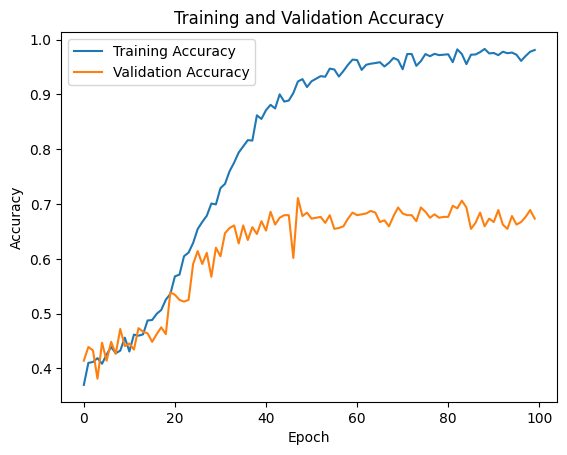

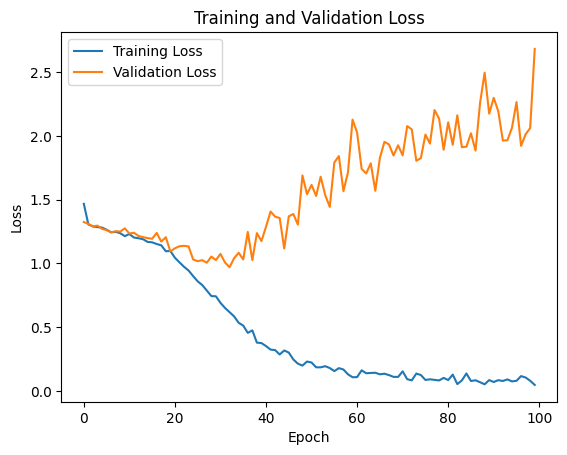

In [ ]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Use the trained model to make predictions on test data
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display the predicted labels
print("Predicted Labels:", predicted_labels)


25/25 [==============================] - 0s 3ms/step
Predicted Labels: [0 2 0 3 1 1 1 2 2 2 1 2 3 1 1 1 2 2 2 2 2 2 1 2 1 1 1 1 1 1 2 2 2 2 1 1 0
 1 3 3 3 2 2 2 2 0 1 1 3 1 1 2 0 2 2 0 1 1 2 2 2 0 2 2 1 3 2 2 2 2 1 1 0 2
 1 2 1 3 2 1 1 1 0 2 3 0 0 1 1 0 0 1 2 1 3 0 2 2 1 2 1 3 1 0 2 1 1 2 1 1 2
 1 3 2 1 2 2 2 2 2 2 3 0 1 1 0 1 1 2 2 1 1 1 0 2 1 2 2 1 2 2 0 3 1 1 2 2 3
 1 1 2 2 2 2 2 2 3 2 2 0 2 2 1 3 2 2 1 2 2 2 3 1 2 2 1 2 3 1 2 2 2 2 0 1 1
 2 2 2 2 2 3 3 1 1 2 2 1 0 2 1 2 2 3 2 2 2 2 2 1 2 1 3 1 2 2 2 2 2 3 2 3 2
 1 0 1 1 1 2 2 2 2 2 1 1 2 2 2 2 1 3 2 3 1 2 2 1 0 1 2 0 1 1 1 3 2 2 1 2 1
 3 1 2 2 2 2 2 1 2 1 1 2 1 1 1 2 0 1 2 2 2 2 2 3 2 0 1 2 1 0 2 2 1 2 1 2 2
 2 2 2 1 1 1 2 2 2 2 2 2 3 2 2 1 3 1 1 1 1 2 3 1 1 1 2 3 2 2 1 2 3 1 3 1 2
 1 1 2 2 0 1 2 1 1 2 2 1 2 1 2 1 2 2 2 1 2 1 2 0 0 2 2 2 2 2 2 2 1 1 2 1 1
 2 1 1 2 1 1 2 2 1 2 2 1 3 2 1 1 1 1 3 2 2 2 0 3 0 3 2 1 2 0 3 2 2 1 2 2 0
 1 2 0 2 3 0 2 0 2 2 2 0 2 0 1 1 1 2 2 2 1 2 2 1 2 1 2 2 3 1 2 1 0 2 3 2 3
 2 1 0 1 2 1 1 2 2 2 0 2 3 1 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert one-hot encoded labels to class labels
true_labels = np.argmax(y_test, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=['none', 'crackles', 'wheezes', 'both']))
print(confusion_matrix(true_labels, predicted_labels))


              precision    recall  f1-score   support

        none       0.61      0.54      0.57        98
    crackles       0.70      0.74      0.72       244
     wheezes       0.77      0.81      0.79       360
        both       0.64      0.50      0.56        98

    accuracy                           0.72       800
   macro avg       0.68      0.65      0.66       800
weighted avg       0.71      0.72      0.71       800

[[ 53  19  20   6]
 [ 18 181  42   3]
 [  5  45 291  19]
 [ 11  12  26  49]]
